In [86]:
import math
import matplotlib.pyplot as plt
import random

# LIF

In [87]:
class LIF():


    def __init__(self, I, t_total_ms=100, dt_ms=0.1, R = 10, tau = 8, neuron_type= 'Inhibitory', threshold=-45,
                 u_rest=-70, u_start=-80, u_reset=-65, u_spike = 5):
        self.I = I
        self.t_total_ms = t_total_ms
        self.dt_ms = dt_ms
        self.R = R
        self.tau = tau
        self.neuron_type = neuron_type
        self.threshold = threshold
        self.u_current = u_start
        self.u_start = u_start
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.u_spike = u_spike
        self.u_arr = []
        self.fire_count = 0


    def run(self):
        t_current_ms = 0
        while t_current_ms <= self.t_total_ms:
            delta_u = self.u_current - self.u_rest

            dudt = (-1 * delta_u + self.R * self.I(t_current_ms))/ self.tau
            
            self.u_current += dudt * self.dt_ms
            is_spike = False
            if self.u_current >= self.threshold:
                self.u_arr.append(self.u_current + self.u_spike)
                self.fire_count += 1
                self.u_current = self.u_reset
                is_spike = True

            self.u_arr.append(self.u_current)

            t_current_ms += self.dt_ms

            yield {'u_current': self.u_current, 'is_spike': is_spike}
    
    def u_plot(self):
        t_arr =  range(len(self.u_arr))
        plt.plot(list(map(lambda i: i * self.dt_ms, t_arr)), self.u_arr, c='g')
        plt.suptitle("LIF", c= 'g', fontsize= 20)
        plt.xlabel("Time (ms)")
        plt.ylabel("Membrane Potential (mv)")
        plt.show()
        print("R: " + str(self.R) +
        "    threshold: " + str(self.threshold) + 
        "    u_rest: " + str(self.u_rest) + 
        "    u_reset: " + str(self.u_reset) + 
        "    u_spike: " + str(self.u_spike) + "\n"+
        "u_start: " + str(self.u_start) +
        "    tau: " + str(self.tau) + 
        "    total time: " + str(self.t_total_ms) + 
        "    dt: " + str(self.dt_ms))



# NeuronsGroup

In [88]:
class NeuronsGroup:

  def __init__(self, neurons, connections, exc_w=10, inh_w=-10, exc_d=1, inh_d=1, total_time=1000):
    self.neurons = neurons
    self.action = []
    for i in neurons:
      self.action.append(i.run()) 

    self.connections = connections
    self.exc_w = exc_w
    self.inh_w = inh_w
    self.exc_d = exc_d
    self.inh_d =  inh_d
    self.total_time = total_time
    self.spikes = []
    self.t_exc_spikes = []
    self.exc_spikes = []
    self.t_inh_spikes = []
    self.inh_spikes = []
    self.s_effect = []

  def run(self):
    
    #create array of zeros for each neurons spikes effect
    self.s_effect = [[0] * len(self.neurons) for p in range(self.total_time)] 
    
    #iterate through total time
    for time in range(self.total_time):  
      #iterate through all neurons actions
      for i in range(len(self.action)):
        a_info = next(self.action[i])
        if a_info['is_spike']:
    
          #iterate through connected neurons 
          for j in self.connections[i]:
            
            #Inhibitory spike
            if self.neurons[i].neuron_type == 'Inhibitory':
              if self.total_time > time + self.exc_d:
                self.s_effect[time + self.inh_d][j] += self.inh_w
              self.inh_spikes.append(i + 1)
              self.t_inh_spikes.append(time)
            
            #Excitatory spike
            if self.neurons[i].neuron_type == 'Excitatory':
              if self.total_time > time + self.inh_d:
                self.s_effect[time + self.exc_d][j] += self.exc_w
              self.exc_spikes.append(i + 1)
              self.t_exc_spikes.append(time)
              
      #add the effect of each neuron to the neurons potential
      for i in range(len(self.neurons)):
        self.neurons[i].u_current += self.s_effect[time][i]
      
  def raster_plot(self):
    plt.scatter(self.t_inh_spikes, self.inh_spikes, color='blue', label = 'Inhibitory')
    plt.scatter(self.t_exc_spikes, self.exc_spikes, color='green', label = 'Excitatory')
    plt.legend(loc="lower right")
   

  def u_plot(self, n_neurons=3):
    if n_neurons < len(self.neurons):
      for i in range(n_neurons):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr, label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
    else:
      for i in range(len(self.neurons)):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr , label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
    
  

### Two Neurons 

In [89]:
I1 = lambda x: 5 
I2 = lambda x: math.sin(x/10)+3

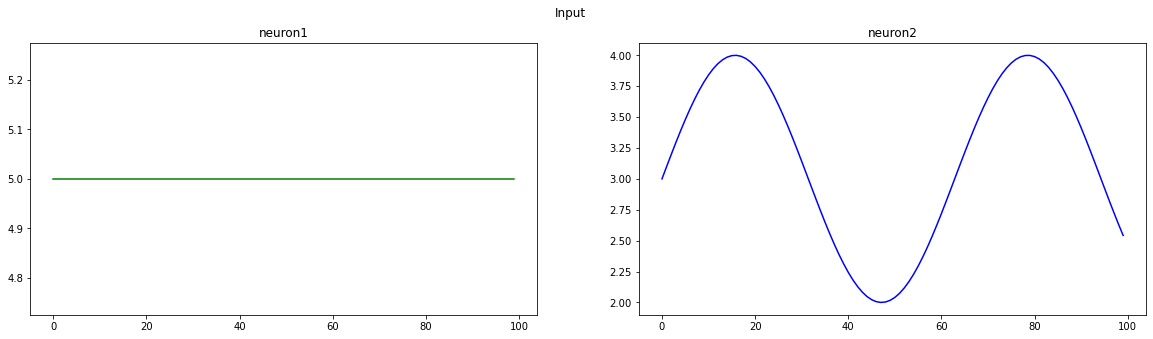

In [90]:
plot, (plt1, plt2) = plt.subplots(1, 2)
plt1.plot(range(100), list(map(I1, range(100))), 'g')
plt1.set_title('neuron1')
plt2.plot(range(100), list(map(I2, range(100))), 'b')
plt2.set_title('neuron2')
plot.suptitle('Input')
plot.set_size_inches(20, 5)



#### Inhibitory - Inhibitory

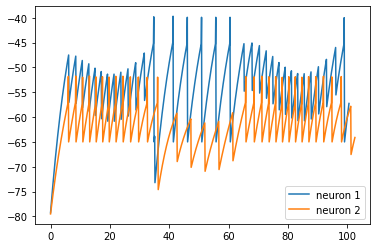

In [91]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2, threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

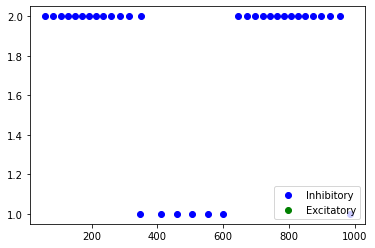

In [92]:
group.raster_plot()

#### Inhibitory - Excitatory

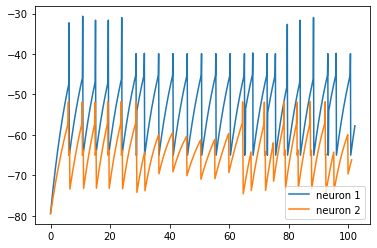

In [93]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2, neuron_type='Excitatory', threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

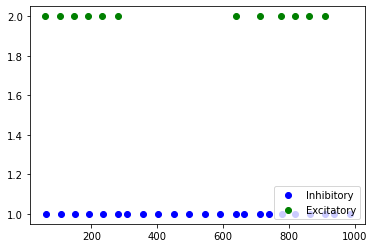

In [94]:
group.raster_plot()

#### Excitatory - Excitatory

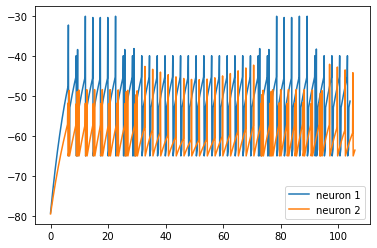

In [95]:
neuron1 = LIF(I=I1, neuron_type='Excitatory')
neuron2 = LIF(I=I2, neuron_type='Excitatory', threshold = -57)

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = NeuronsGroup(neurons, connections)
group.run()
group.u_plot()

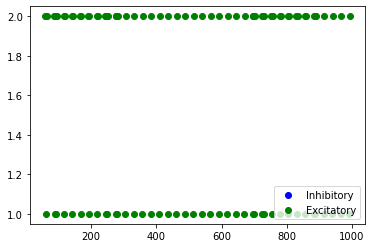

In [96]:
group.raster_plot()

### Multiple Neurons 

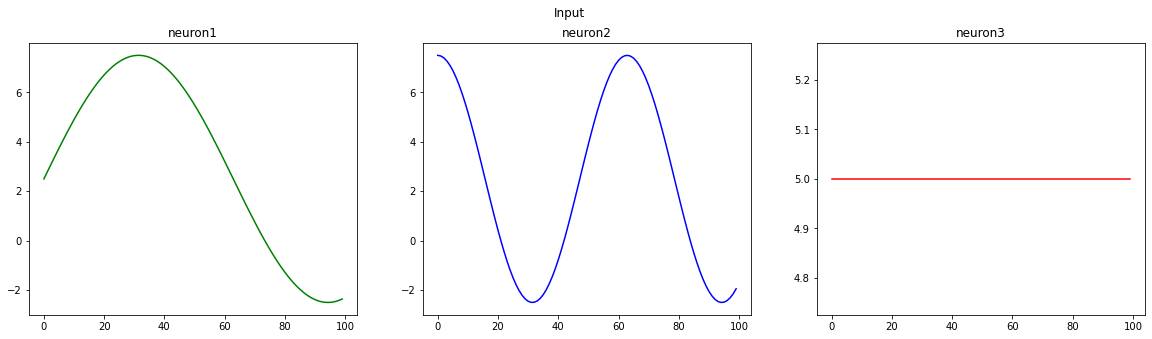

In [97]:
I1 = lambda x: (math.sin(x/20) + 0.5) * 5
I2 = lambda x: (math.cos(x/10) + 0.5) * 5
I3 = lambda x: 5

plot, (plt1, plt2, plt3) = plt.subplots(1, 3)
plt1.plot(range(100), list(map(I1, range(100))), 'g')
plt1.set_title('neuron1')
plt2.plot(range(100), list(map(I2, range(100))), 'b')
plt2.set_title('neuron2')
plt3.plot(range(100), list(map(I3, range(100))), 'r')
plt3.set_title('neuron3')
plot.suptitle('Input')
plot.set_size_inches(20, 5)



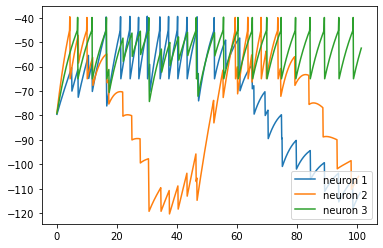

In [98]:
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2)
neuron3 = LIF(I=I3, neuron_type='Excitatory')

neurons = [neuron1, neuron2, neuron3]
connections = [[1,2], [0], [0,1]]
group = NeuronsGroup(neurons, connections, inh_d=6, exc_w=-12)
group.run()
group.u_plot()

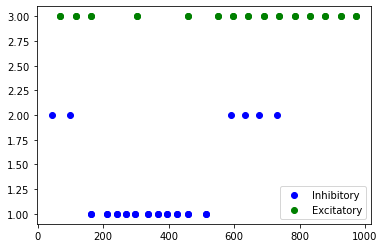

In [99]:
group.raster_plot()

# Neurons Group

In [100]:
def create_group(exc_count, inh_count, exc_chance, inh_chance, I):
      
  neurons_count = inh_count + exc_count
  neurons = []
  total_connections = []
  
  inh_connections = int(neurons_count * inh_chance)
  exc_connections = int(neurons_count * exc_chance)
    
  for i in range(inh_count):
    neuron = LIF(I, neuron_type = 'Inhibitory')
    neurons.append(neuron)
    random_inh_connections = random.sample(range(neurons_count), inh_connections)
    total_connections.append(random_inh_connections)
    
  for i in range(exc_count):
    neuron = LIF(I, neuron_type = 'Excitatory')
    neurons.append(neuron)
    random_exc_connections = random.sample(range(neurons_count), exc_connections)
    total_connections.append(random_exc_connections)

    
  neurons_group = NeuronsGroup(neurons, total_connections)
  return neurons_group
   



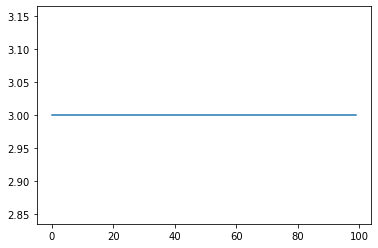

In [101]:
plt.plot(range(100), list(map(lambda x: 3, range(100))))


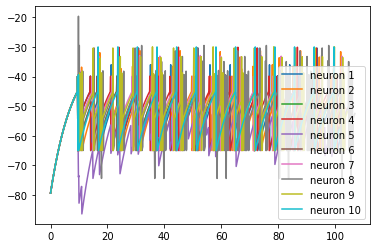

In [110]:
I = lambda x: 4

group = create_group(8, 2, 0.2, 0.1, I)

group.run()
group.u_plot(10)

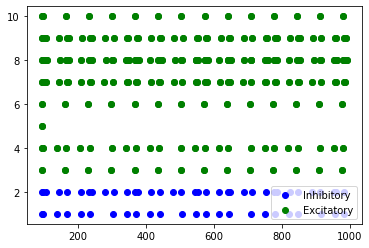

In [111]:
group.raster_plot()

### All neurons connected

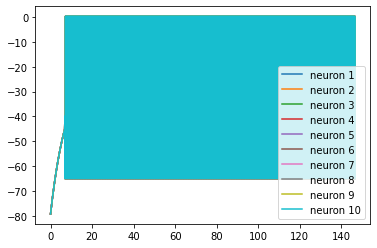

In [104]:
I = lambda x: 5
    
group = create_group(8, 2, 1, 1, I)

group.run()
group.u_plot(10)

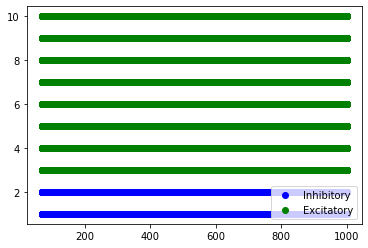

In [105]:
group.raster_plot()